In [1]:
%load_ext autoreload
%autoreload 2

### SetUp

In [1]:
# !git clone https://github.com/InesVATI/active_contour_cnn.git

# %cd active_contour_cnn/src

Cloning into 'active_contour_cnn'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 1), reused 23 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 681.52 KiB | 5.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/active_contour_cnn/src


In [3]:
# %ls

In [1]:
# !pip install pydicom

In [2]:
import pydicom as dicom
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
from typing import Literal
import time

from models import LayerFCN8
from datasets import save_multilayer_label_map, CHAOSDataset

root_dir = os.path.dirname(os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cpu


In [3]:
patient_ids = os.listdir(os.path.join(root_dir, '__data', 'Train_Sets', 'CT'))
nb_images = [len(os.listdir(os.path.join(root_dir, '__data', 'Train_Sets', 'CT', id, 'Layer_label_map'))) for id in patient_ids]
nb_images

[89,
 97,
 83,
 89,
 105,
 90,
 70,
 148,
 89,
 148,
 80,
 108,
 85,
 149,
 102,
 121,
 164,
 91,
 79,
 79]

In [5]:
# # Download data
# data_folder = '{}/__data/'.format(root_dir)
# if not os.path.exists(data_folder):
#   !gdown --fuzzy 'https://drive.google.com/file/d/15GedlUNuP57IisUftw-iywgCdI8hMcNA/view?usp=sharing' -O $data_folder

Downloading...
From (original): https://drive.google.com/uc?id=15GedlUNuP57IisUftw-iywgCdI8hMcNA
From (redirected): https://drive.google.com/uc?id=15GedlUNuP57IisUftw-iywgCdI8hMcNA&confirm=t&uuid=5c28dd6a-3627-44b4-815e-9b5bd95cff11
To: /content/active_contour_cnn/__data/Train_Sets.zip
100% 813M/813M [00:04<00:00, 196MB/s]


In [3]:
# if os.path.exists(f'{root_dir}/__data/Train_Sets.zip'):
#   file_path = f'{root_dir}/__data/Train_Sets.zip'
#   !unzip $file_path -d $data_folder
# else :
#   print('Issue while downloading data')

In [4]:
data_folder = os.path.join(root_dir, '__data', 'Train_Sets', 'CT')
test_data_folder = os.path.join(root_dir, '__data', 'Test_Sets')
result_folder = f'{root_dir}/__results/'
figure_folder = f'{root_dir}/figures'

## Visualize generated layer label map

In [94]:
# save_multilayer_label_map(data_folder, d=5)

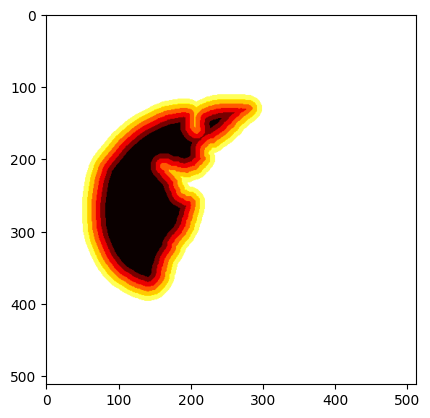

In [98]:
with open(os.path.join(data_folder, '5', 'Layer_label_map', 'GT_map_060.npy'), 'rb') as f:
    label_map = np.load(f)

plt.imshow(label_map, cmap='hot')          

91
Img id  5
Input image shape (512, 512) min 0 max 2285
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.027873992919921875
pixel spacing [0.791015625, 0.791015625]
Img id  60
Input image shape (512, 512) min 0 max 2189
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.051792144775390625
pixel spacing [0.791015625, 0.791015625]


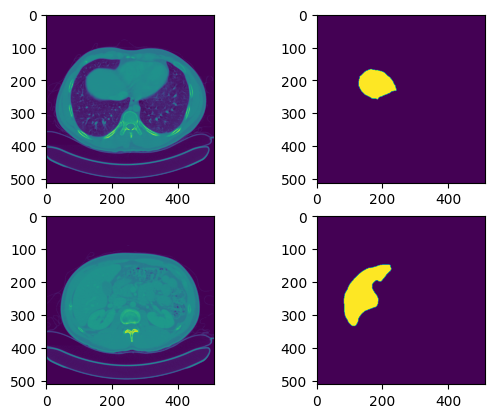

In [80]:
patient_id = 0
a=300
for i, patient_id in enumerate([3, 5]):
    img_id = [5, 60]
    files = sorted(os.listdir(data_folder))

    dicom_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/DICOM_anon"))
    ground_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/Ground"))
    print(len(dicom_files))
    ds0 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[0]]))
    label_map0 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[0]]))
    label_map0 = np.array(label_map0).astype(float)
    print("Img id ", img_id[0])
    print('Input image shape', ds0.pixel_array.shape, 'min', ds0.pixel_array.min(), 'max', ds0.pixel_array.max())
    print(f"Label size : {label_map0.shape}; type {label_map0.dtype}; min : {label_map0.min()}; max : {label_map0.max()}; mean : {label_map0.mean()}")
    print('pixel spacing', ds0.PixelSpacing)

    ds1 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[1]]))
    label_map1 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[1]]))
    label_map1 = np.array(label_map1).astype(float)
    print("Img id ", img_id[1])
    print('Input image shape', ds1.pixel_array.shape, 'min', ds1.pixel_array.min(), 'max', ds1.pixel_array.max())
    print(f"Label size : {label_map1.shape}; type {label_map1.dtype}; min : {label_map1.min()}; max : {label_map1.max()}; mean : {label_map1.mean()}")
    print('pixel spacing', ds1.PixelSpacing)

    # img0 = ( ds0.pixel_array - ds0.pixel_array.min()) / (ds0.pixel_array.max() - ds0.pixel_array.min())
    # img1 = ( ds1.pixel_array - ds1.pixel_array.min()) / (ds1.pixel_array.max() - ds1.pixel_array.min())

    fig = plt.figure()
    fig.add_subplot(2, 2, 1)
    plt.imshow(ds0.pixel_array) # , cmap='gray'
    fig.add_subplot(2, 2, 2)
    plt.imshow(label_map0)

    fig.add_subplot(2, 2, 3)
    plt.imshow(ds1.pixel_array)
    fig.add_subplot(2, 2, 4)
    plt.imshow(label_map1)

    plt.show()
    break

Distance to background : min : -45.17742799230607; max : 406.06034034364893


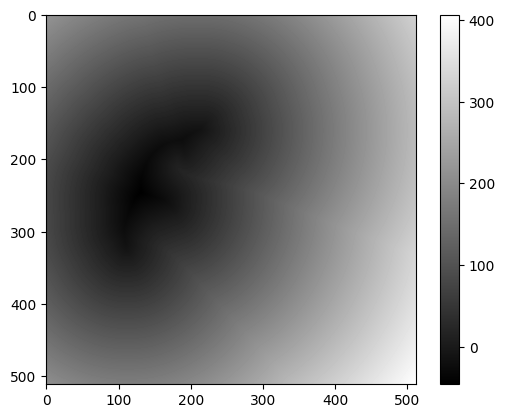

In [81]:
signed_dist = ndimage.distance_transform_edt(1 - label_map1) - ndimage.distance_transform_edt(label_map1)
print(f"Distance to background : min : {signed_dist.min()}; max : {signed_dist.max()}")

plt.imshow(signed_dist, cmap='gray')
plt.colorbar()
plt.show()


Delta : 6.320987654320987
Label -3 size : 5798
Label 3 size : 239243
Label -2 size : 2918
Label -1 size : 2626
Label 0 size : 4575
Label 1 size : 3064
Label 2 size : 3920


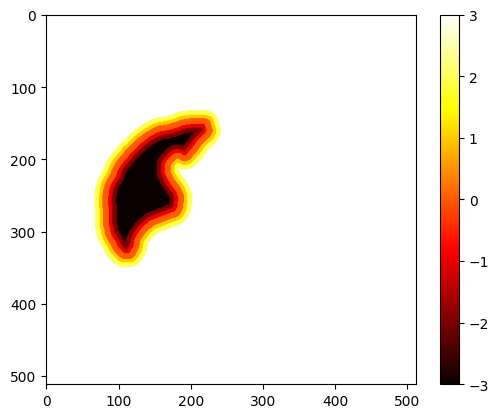

In [90]:
d = 5
delta = d / ds1.PixelSpacing[0]
print(f"Delta : {delta:.3f}")
N = 4
layer_label_map = np.zeros_like(label_map1)
layer_label_map[ signed_dist <= (- N+2 - 0.5)*delta] = -N+1
print(f"Label {-N+1} size : {np.sum(layer_label_map == -N+1)}")
layer_label_map[ signed_dist > (N - 1.5)*delta] = N-1
print(f"Label {N-1} size : {np.sum(layer_label_map == N-1)}")
a = 1.4
for i in range(-N+2, N-1):
    if i==0:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*(delta*a))
    elif i==-1:
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*(a*delta))
    elif i==1:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*delta)
    else :
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*delta)
    layer_label_map[cond] = i
    print(f'Label {i} size : {np.sum(cond)}')


fig = plt.figure()
plt.imshow(layer_label_map, cmap='hot') # [100:300, 100:300]
plt.colorbar()
plt.show()

In [85]:
(layer_label_map == 3).sum()

239243

(512, 512)


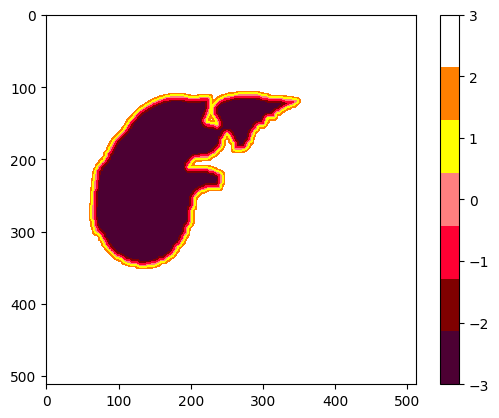

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

layer_label_map = np.load(os.path.join(data_folder, '8', 'Layer_label_map', 'GT_map_050.npy'))
print(layer_label_map.shape)

colors = [(0.3, 0, 0.2), (0.5, 0, 0), (1, 0, 0.2), (1, 0.5, 0.5), (1, 1, 0), (1, .5, 0), (1, 1, 1)] #  (.5, .5, 1),
cmap_name = 'my_list'
n_bin = 7

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

fig, ax = plt.subplots()
im = ax.imshow(layer_label_map, cmap=cmap)

fig.colorbar(im, ax=ax)

plt.show()

## Get familiar with convolutions

In [ ]:
# inp = torch.randn(1, 16, 12, 12)

# downsample = torch.nn.Conv2d(16, 16, 3, stride=2, padding=0)
# upsample = torch.nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0)

# out = downsample(inp)
# print(out.shape)
# out = upsample(out)
# print(out.shape)

c:\Users\INES\Documents\3A_MVA\DeformableModelsGeodesics\active_contour_cnn/__data/Train_Sets/CT
img torch.Size([512, 512])


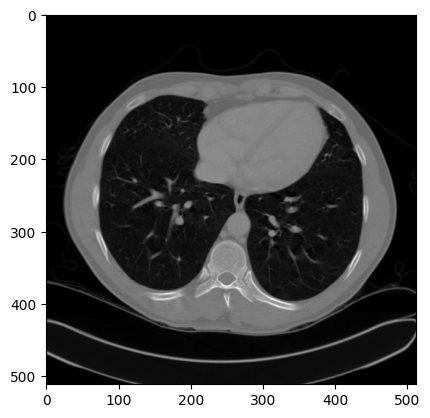

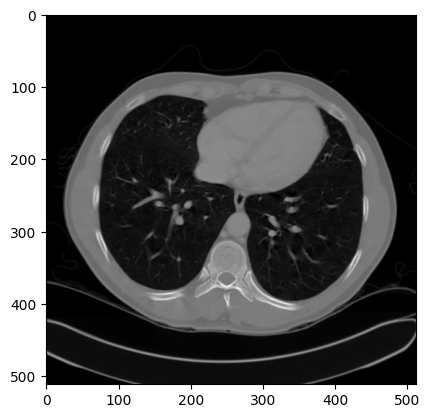

In [ ]:
data_folder = root_dir + '/__data/Train_Sets/CT'
print(data_folder)

patient = 8
dicom_files = os.listdir(f"{data_folder}/{patient}/DICOM_anon/")
with open(f"{data_folder}/{patient}/DICOM_anon/{dicom_files[0]}", 'rb') as file:
    ds = dicom.dcmread(file)

img = torch.tensor(ds.pixel_array.astype(np.float32))
img = (img - img.min()) / (img.max() - img.min())
print('img', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

# .view(1, *img.shape)
imgRGB = img.expand(3, -1, -1).contiguous() # expand better for memory than repeat
plt.imshow(imgRGB.permute(1, 2, 0))
plt.show()

In [ ]:
data = CHAOSDataset(data_folder)

In [ ]:
nb_data = len(data)
print(nb_data)

2066


In [ ]:
i = np.random.randint(0, nb_data)
inp, target = data[i]
print('inp', inp.shape)
print('target', target.shape)

inp torch.Size([3, 512, 512])
target (512, 512)


In [ ]:
target = torch.tensor(target + target.max() + 1, dtype=torch.float32)

In [ ]:
torch.unique(target)

tensor([1., 2., 3., 4., 5., 6., 7.])

## Train FCN

In [8]:
# download model pretrained weights file
!gdown --fuzzy 'https://drive.google.com/file/d/1T2v4kdTY9l2drUooRGendYWoEgRvBeL6/view?usp=sharing' -O $result_folder

Downloading...
From (original): https://drive.google.com/uc?id=1T2v4kdTY9l2drUooRGendYWoEgRvBeL6
From (redirected): https://drive.google.com/uc?id=1T2v4kdTY9l2drUooRGendYWoEgRvBeL6&confirm=t&uuid=78a0f3eb-4ea8-4a58-8ed3-edc21acc5112
To: /content/active_contour_cnn/__results/fcn8s-heavy-pascal.pth
100% 538M/538M [00:06<00:00, 86.8MB/s]


In [9]:
dataset = CHAOSDataset(data_folder)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.95, 0.03, .02])

print(f'Nb train data : {len(train_dataset)}\n'
      f'Nb val data : {len(val_dataset)}\n'
      f'Nb test data : {len(test_dataset)}\n')


Nb train data : 1963
Nb val data : 62
Nb test data : 41



In [10]:
class EarlyStopping:
    def __init__(self, patience:int=5, min_delta:float = 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_loss = None
        self.counter = 0

    def __call__(self, val_loss : float):

        if self.prev_loss is None:
            self.prev_loss = val_loss
            return False

        if np.abs(self.prev_loss - val_loss) < self.min_delta:
            self.counter += 1
        else:
            self.counter = 0

        self.prev_loss = val_loss

        if self.counter >= self.patience:
            return True

        return False


In [23]:
t[0].unique()

tensor([0, 1, 2, 3, 4, 5, 6])

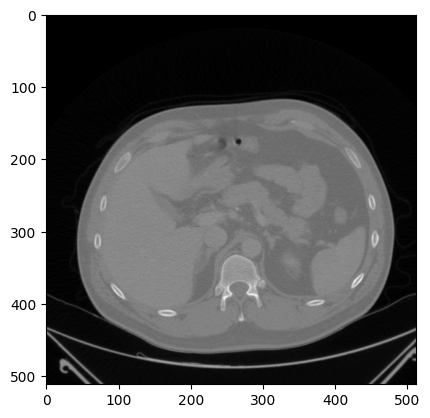

In [25]:
plt.imshow(x[0].permute(1, 2, 0))

In [ ]:
modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
modelFCN = modelFCN.to(device)

# freeze pretrained layers
for name, param in modelFCN.named_parameters():
    if 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
modelFCN.score_fr.weight.data

In [31]:
modelFCN.upscore2.weight.data

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5

In [32]:
x, t = next(iter(train_loader))
out = modelFCN(x.to(device))

In [35]:
def train(model : torch.nn.Module, optimizer : torch.optim,
          train_dataloader : DataLoader, val_dataloader : DataLoader,
          lr_scheduler : torch.optim.lr_scheduler = None,
          early_stopper : EarlyStopping = None,
          nepochs_max:int=100):

    criterion = torch.nn.CrossEntropyLoss()
    train_loss, val_loss = [], []

    for epoch in range(nepochs_max):
        bs_train_loss = 0
        bs_val_loss = 0
        train_bs, val_bs = 0, 0
        model.train()

        for (inp, target) in train_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            bs_train_loss += loss.item()
            train_bs += 1

        train_loss.append(bs_train_loss / train_bs)

        with torch.no_grad():
            model.eval()
            for (inp, target) in val_dataloader:
                inp = inp.to(device)
                target = target.to(device)
                output = model(inp)
                loss = criterion(output, target)
                bs_val_loss += loss.item()
                val_bs += 1

            val_loss.append(bs_val_loss / val_bs)
        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch} : train loss {train_loss[-1]:.3f}, val loss {val_loss[-1]:.3f}')

        if lr_scheduler is not None:
            lr_scheduler.step()

        if early_stopper is not None:
            print('stopper count', early_stopper.counter)
            if early_stopper(val_loss[-1]):
                print(f'Early stopping at epoch {epoch}')
                break

    return train_loss, val_loss

def compute_test_loss(model, test_dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    test_bs = 0
    model.eval()
    with torch.no_grad():
        for (inp, target) in test_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            output = model(inp)
            loss = criterion(output, target)
            test_loss += loss.item()
            test_bs += 1

    return test_loss / test_bs

def plot_learning_curves(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [36]:
batch_size = 20 # 20
lr = 0.0005 #0.00005
momentum = 0.9
nepochs = 100

modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
modelFCN = modelFCN.to(device)

# freeze pretrained layers
for name, param in modelFCN.named_parameters():
    if 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs)  #, eta_min=0.0000001

early_stopper = EarlyStopping(patience=5, min_delta=1e-4)



In [ ]:
train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs,
                             lr_scheduler=scheduler,
                             early_stopper=early_stopper)
plot_learning_curves(train_loss, val_loss)

Epoch 0 : train loss 0.829, val loss 0.481
stopper count 0
Epoch 1 : train loss 0.424, val loss 0.488
stopper count 0
Epoch 2 : train loss 0.417, val loss 0.399
stopper count 0
Epoch 3 : train loss 0.419, val loss 0.416
stopper count 0
Epoch 4 : train loss 0.410, val loss 0.382
stopper count 0
Epoch 5 : train loss 0.407, val loss 0.406
stopper count 0
Epoch 6 : train loss 0.403, val loss 0.379
stopper count 0
Epoch 7 : train loss 0.401, val loss 0.403
stopper count 0
Epoch 8 : train loss 0.401, val loss 0.470
stopper count 0
Epoch 9 : train loss 0.398, val loss 0.401
stopper count 0
Epoch 10 : train loss 0.394, val loss 0.426
stopper count 0
Epoch 11 : train loss 0.397, val loss 0.368
stopper count 0
Epoch 12 : train loss 0.396, val loss 0.387
stopper count 0
Epoch 13 : train loss 0.392, val loss 0.395
stopper count 0
Epoch 14 : train loss 0.390, val loss 0.376
stopper count 0
Epoch 15 : train loss 0.394, val loss 0.412
stopper count 0
Epoch 16 : train loss 0.390, val loss 0.382
stoppe

In [ ]:
test_loss = compute_test_loss(modelFCN, test_loader)
print(f'Test loss of trained model : {test_loss}')

In [ ]:
torch.save(modelFCN.state_dict(), f'{result_folder}/modelFCN8.pth')

In [ ]:
train_img, train_lab = next(iter(train_loader))
train_img = train_img[0].to(device)
train_lab = train_lab[0]
print('t1', train_img.shape)


In [ ]:
out = modelFCN(train_img.unsqueeze(0))

pred_label_map = torch.argmax(out, dim=1)
print(pred_label_map.shape)

In [ ]:
pred_label_map

In [ ]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(train_img.permute(1, 2, 0).cpu())

plt.subplot(1, 3, 2)
plt.imshow(pred_label_map.squeeze().detach().cpu(), cmap='hot')
plt.title('Prediction')

plt.subplot(1, 3, 3)
plt.imshow(train_lab, cmap='hot')
plt.title('Target')


plt.show()

In [ ]:
# Unfreeze parameters and retrain
for param in modelFCN.parameters():
  param.requires_grad = True

lr = 1e-5
nepochs = 50
momentum = .9
optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)

train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs,
                             lr_scheduler=None,
                             early_stopper=early_stopper)
plot_learning_curves(train_loss, val_loss)


## ACM

In [5]:
# !git clone https://github.com/TheoBertrand-Dauphine/MVA_NT_geodesic_methods

In [6]:
# !pip install scikit-fmm # for re-distancing # in colab
# %pip install scikit-fmm # jupyter notebook

In [5]:
import MVA_geodesic_methods.nt_toolbox.grad as toolgrad
import MVA_geodesic_methods.nt_toolbox.div as tooldiv

# from MVA_geodesic_methods.nt_toolbox.general import toolgeneral
import MVA_geodesic_methods.nt_toolbox.signal as toolsignal
from MVA_geodesic_methods.nt_toolbox.plot_levelset import plot_levelset

from MVA_geodesic_methods.nt_toolbox.perform_redistancing import perform_redistancing

from scipy import signal

In [6]:
# Load test data
patient_ids = os.listdir(os.path.join(test_data_folder))
test_dicom_files = []
test_layer_label_map_files = []
for id in patient_ids:
    test_dicom_files += ["/".join([id, 'DICOM_anon', name]) for name in os.listdir(os.path.join(test_data_folder, id, 'DICOM_anon'))]
    test_layer_label_map_files += ["/".join([id, 'Layer_label_map', name]) for name in os.listdir(os.path.join(test_data_folder, id, 'Layer_label_map'))]
print(test_dicom_files)
print(test_layer_label_map_files)

['14/DICOM_anon/i0012,0000b.dcm', '14/DICOM_anon/i0013,0000b.dcm', '14/DICOM_anon/i0014,0000b.dcm', '26/DICOM_anon/IMG-0009-00028.dcm', '26/DICOM_anon/IMG-0009-00032.dcm', '26/DICOM_anon/IMG-0009-00033.dcm']
['14/Layer_label_map/GT_map_012.npy', '14/Layer_label_map/GT_map_013.npy', '14/Layer_label_map/GT_map_014.npy', '26/Layer_label_map/GT_map_028.npy', '26/Layer_label_map/GT_map_032.npy', '26/Layer_label_map/GT_map_033.npy']


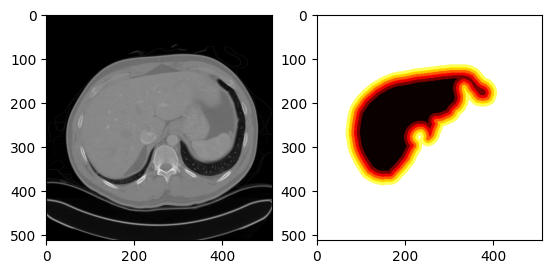

In [7]:
img_id = 4
with open(os.path.join(test_data_folder, test_layer_label_map_files[img_id]), 'rb') as f:
    gt_label_map = np.load(f)
with open(os.path.join(test_data_folder, test_dicom_files[img_id]), 'rb') as f:
    ds = dicom.dcmread(f)
    img = ds.pixel_array
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(gt_label_map, cmap='hot')  
plt.show()

### Use GT layer map

In [8]:
def get_initial_levelset(layer_label_map, threshold : int = 0):
    seg_map = np.where( layer_label_map < threshold, 1, 0)
    phi0 = ndimage.distance_transform_edt(1 - seg_map) - ndimage.distance_transform_edt(seg_map)
    return phi0

phi0 (512, 512)


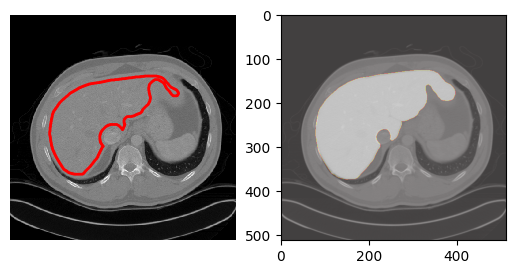

In [11]:
phi0 = get_initial_levelset(gt_label_map, threshold=-1)
print('phi0', phi0.shape)

# enhanced_img = np.where(img<1e-1, 10*img, img)
# plot_levelset(phi0, 0, enhanced_img )
# plt.show()
plt.subplot(1, 2, 1)
plot_levelset(phi0, 0, img )
# plt.imshow(pred_label_map<=0, cmap='hot', alpha=.5)

plt.subplot(1, 2, 2)
plt.imshow(gt_label_map<=0, cmap='hot', alpha=.5)
plt.imshow(img, cmap='gray', alpha=.5)

### Compute model's output

In [12]:
def get_predicted_layer_label_map(output : torch.tensor, nclass=7) -> np.ndarray:
  """
  Convert model's output with value in {0, nclass-1} to value in {-n/2, ..., 0, ..., n/2}
  corresponding to layer index
  :param output: model's output of size (1, nclass, H, W)
  """
  pred_label_map = torch.argmax(output.squeeze(0), dim=0)
  t = int((nclass-1)/2)
  label_map = (pred_label_map - t).detach().numpy()

  return label_map

In [13]:
# Extract initial curve from FCN model output
saved_modelFCN = LayerFCN8()
saved_modelFCN.load_state_dict(torch.load(f'{result_folder}/modelFCN8_retrained_e100.pth', map_location=device))
saved_modelFCN.eval()

LayerFCN8(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_si

In [14]:
imgRGB = torch.tensor(img, dtype=torch.float32)
imgRGB = imgRGB.expand(3, -1, -1).contiguous()
print('imgRGB', imgRGB.shape)
output = saved_modelFCN(imgRGB.unsqueeze(0).to(device))
print('out', output.shape)
pred_label_map = get_predicted_layer_label_map(output)
print('label_map', pred_label_map.shape)
print(np.unique(pred_label_map, return_counts=True))

imgRGB torch.Size([3, 512, 512])
out torch.Size([1, 7, 512, 512])
label_map (512, 512)
(array([-3, -2, -1,  0,  1,  2,  3], dtype=int64), array([ 25109,   5428,   8697,   8244,   7560,  19164, 187942],
      dtype=int64))


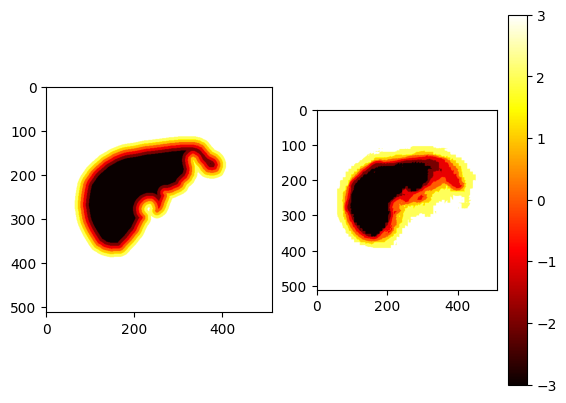

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(gt_label_map, cmap='hot')

plt.subplot(1, 2, 2)
plt.imshow(pred_label_map.squeeze(), cmap='hot')
plt.colorbar()
plt.show()

### ACM model

Level set formalism  : $$\{\gamma(s), s\in[0, 1]\} = \{x\in\mathbb{R}^2, \varphi = 0\} $$
We add a localized or global region-based Chan-Vese force model

$$\underset{\gamma}{\min} \int_0^1 W(\gamma (s))||\gamma '(s)||ds + \lambda_1 \int_{\Omega} F_{CV}(x) d x + \lambda_2\int_\Omega F_{FCN}(x)dx$$
the first term is the weighted length of the curve $\gamma$ and
$F_{CV} = |I(x)-c_{1,x}|^2 d x \mathbf{1}_{\phi(x)>0}   -
       |I(x)-c_{2,x}|^2\mathbf{1}_{\phi(x)<0}$

$W(x) = \alpha + \frac{\beta}{\epsilon + d(x)}$ where $d = ||\nabla I||*h_a$
where $h_a$ is a blurring kernel of size $a > 0$



Mean Curvature Motion : The solution satifies 
$$\frac{\partial\varphi_t}{\partial t} = G(\varphi_t)$$

where 
\begin{align*} 
G(\varphi_t) &=  W ||\nabla\varphi || \textrm{div}\left(\frac{\nable\varphi}{||\nabla\varphi||} \right) - \langle\nabla W, \nabla \varphi \rangle \\
&+ \lambda(I - c_1)^2 - \lambda \\
\end{align} 

In [103]:
# n = img.shape[0]
# X, Y = np.meshgrid(np.arange(n), np.arange(n))

In [16]:
def compute_local_mean(img : np.ndarray, phi : np.ndarray, r: int = 3):
    # local_mean = ndimage.uniform_filter(img, size=r, mode='mirror')
    int_img = np.where(phi <= 0, img, 0)
    ext_img = np.where(phi > 0, img, 0)
    kernel = np.ones((r, r))/r**2
    local_mean_int = signal.convolve2d(int_img, kernel, mode='same', boundary='symm')
    local_mean_ext = signal.convolve2d(ext_img, kernel, mode='same', boundary='symm')

    return local_mean_int, local_mean_ext

def compute_global_mean(img : np.ndarray, phi : np.ndarray):
    cst_int = np.mean(img[phi<=0])
    cst_ext = np.mean(img[phi>0])

    return cst_int, cst_ext

In [13]:
# from scipy import ndimage 

# img = 2*np.arange(4).reshape(2, 2)
# print(img)
# img = np.repeat(img, 4, axis=0)
# img = np.repeat(img, 4, axis=1)

# plt.subplot(1, 2, 1)
# plt.imshow(img)

# plt.subplot(1, 2, 2)
# # local_mean = ndimage.uniform_filter(img, size=3, mode='mirror')

# local_mean, _ = compute_local_mean(img, -np.ones_like(img), r=3)
# plt.imshow(local_mean)
# plt.colorbar()
# plt.show()


In [14]:
img.shape

(512, 512)

Text(0.5, 1.0, 'Norm of gradient of smoothed image')

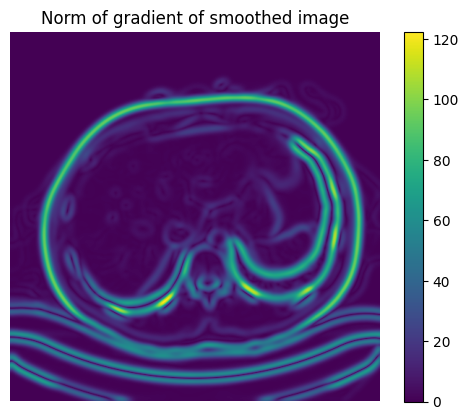

In [23]:
kernel_size = 60
sigma = .05
x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
kernel = np.exp(- (((x-1)/kernel_size - .5)**2 + ((y-1)/kernel_size-.5)**2)/ (4*sigma**2))/sigma

d = signal.convolve2d(img, kernel, boundary='symm', mode='same')
grad_d = toolgrad.grad(d, order=2)
norm_grad_d = np.sqrt( np.sum(grad_d**2, 2))

plt.imshow(norm_grad_d)
plt.colorbar()
# plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.axis('off')
plt.title('Norm of gradient of smoothed image')

min W 0.008172775835231152 max W 10.0
min W 0.01 max W 0.9999999999999999


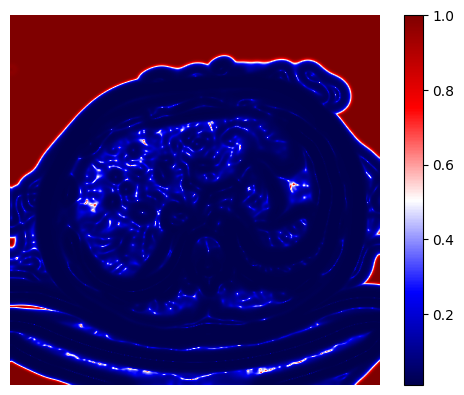

In [25]:
epsilon = 1e-1
W = 1./(epsilon + norm_grad_d)

# rescale W
print('min W', W.min(), 'max W', W.max())
wmin, wmax = W.min(), W.max()
W = (W - wmin )*.99 / (wmax - wmin) + .01
print('min W', W.min(), 'max W', W.max())

plt.imshow(W, cmap='seismic')
plt.colorbar()
plt.axis('off')
plt.show()

### Implement ACM resolution

In [17]:
def compute_edge_info(img, kernel_size=60, sigma=.05):

    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    kernel = np.exp(- (((x-1)/kernel_size - .5)**2 + ((y-1)/kernel_size-.5)**2)/ (4*sigma**2))/sigma
    smooth_img = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    grad_smooth = toolgrad.grad(smooth_img, order=2)
    norm_grad_smooth = np.sqrt( np.sum(grad_smooth**2, 2))

    epsilon = 1e-1
    W = 1./(epsilon + norm_grad_smooth)

    # rescale W
    wmin, wmax = W.min(), W.max()
    W = (W - wmin )*.99 / (wmax - wmin) + .01
    grad_W = toolgrad.grad(W, order=2)
    return W, grad_W

In [21]:
def solve_acm(img : np.ndarray, 
              layer_label_map : np.ndarray,
              phi0 : np.ndarray,
              tau : float = .5,
              niter: int = 500,
              redistancing_occur : int = 10,
              weights : list = None,
              chan_vese : Literal['Local', 'Global'] = None,
              local_region_r : int = 8,
              polynomial_fcn_force_order : int = None, 
              add_edge_info: bool = False,
              verbose : bool = False):
    """
    Iterative algorithm to solve the Euler Lagrange equation associated with level set formalism

    :param redistancing_occur: int, re-distancing of $\phi$ is performed every redistancing_occur iteration 
    :param local_region_r: int, local region radius to compute the local region-based energy when chan_vese is 'Local', 
    :param polynomial_fcn_force_order: int, If None (default), the strength of the steering force from the FCN 
                     : has an exponential relationship with its distance to the boundary 
    :param verbose : bool, plot figures for verification 
    """
    eps = np.finfo(float).eps
    verbose_nrep = 100
    config = ''
    if chan_vese:
        assert chan_vese.lower() in ['local', 'global'], f'{chan_vese} Chan Vese is not recognized. chan_vese is either "local" or "global"'
        config += f'_CV{chan_vese.lower()}'

    if weights is None:
        weights = [0.6, .4]
        if chan_vese:
            weights += [1.0]
    else :
        if chan_vese: # if user chooses to add region-based energy, check the weights list has the correct length
            assert len(weights) >= 3, f'For {chan_vese} region-based Chan Vese energy, not enough weigths to balance the forces.'
    config += f'_w{weights}'

    # Precompute F_FCN
    if polynomial_fcn_force_order :
        assert polynomial_fcn_force_order >= 1
        F_FCN = np.sign(layer_label_map) * np.abs(layer_label_map)**polynomial_fcn_force_order
        config += f'_FCNorder{polynomial_fcn_force_order}'
    else :
        F_FCN = np.sign(layer_label_map) * np.exp(np.abs(layer_label_map))
        F_FCN /= (np.sqrt(np.sum(F_FCN**2)) + eps)# normalize the strength
        config += '_FCNexp'

    if verbose:
        plt.imshow(F_FCN)
        plt.title('$F_{FCN}$')
        plt.colorbar()
        plt.show()

    # Add edge information
    if add_edge_info:
        W, grad_W = compute_edge_info(img)
        config += '_edgeInfo'
    else :
        W = 1.

    if verbose and add_edge_info:
        plt.subplot(1, 2, 1)
        plt.imshow(W, cmap='seismic')
        plt.colorbar()
        plt.title('W')
        plt.subplot(1, 2, 2)
        plt.imshow(grad_W[..., 0])
        plt.title(r'$\nabla W_x$')
        plt.colorbar()
        plt.show()

    phi = phi0.copy()

    fig = plt.figure(figsize = (25, 8))
    d = 200
    total_subplots = niter // 200
    s = 1
    for i in range(niter):

        # Add internal and FCN forces
        grad_phi = toolgrad.grad(phi, order=2)
        norm_grad_phi = np.sqrt( np.sum(grad_phi**2, 2))
        normal_vect = grad_phi / (norm_grad_phi[..., np.newaxis] + eps)

        curvature = tooldiv.div(normal_vect[..., 0], normal_vect[..., 1], order=2)
        G = - weights[0] * W * norm_grad_phi * curvature - weights[1] * F_FCN 

        if verbose and i%verbose_nrep == 0:
            print('\nIter', i)
            print(f'curvature {curvature.min():.3f} {curvature.max():.3f} mean {curvature.mean():.3f}')
            print(f'norm_grad_phi {norm_grad_phi.min():.3f} {norm_grad_phi.max():.3f} mean {norm_grad_phi.mean():.3f}')
        
        if add_edge_info:
            inner_prod_grad = np.einsum( 'ijk, ijd -> ij', grad_W, grad_phi)
            G = G - weights[0]*inner_prod_grad
            if verbose and i%verbose_nrep == 0:
                print(f'inner_prod_grad {inner_prod_grad.min():.3f} {inner_prod_grad.max():.3f} mean {inner_prod_grad.mean():.3f}')
        
        # Add region-based forces
        if chan_vese:
            args = {'img' : img,
                    'phi' : phi}
            if chan_vese.lower() == 'local':
                args['r'] = local_region_r
            chan_vese_func = eval(f'compute_{chan_vese.lower()}_mean')
            c_int, c_ext = chan_vese_func(**args)
            F_CV = (img - c_ext)**2 - (img - c_int)**2
            G += weights[2]*F_CV #* approx_delta_phi 

            if verbose and i%verbose_nrep == 0:
                print(f'F_CV {F_CV.min():.3f}, {F_CV.max():.3f} mean {F_CV.mean():.3f}')

        # Gradient descent
        phi = phi - tau*G
        if verbose and i%verbose_nrep == 0:
            print(f'G {G.min():.3f} {G.max():.3f} mean {G.mean():.3f}')
            print(f'phi {phi.min():.3f} {phi.max():.3f} mean {phi.mean():.3f}')

        # re-distancing
        if i % redistancing_occur == 0:
            phi = perform_redistancing(phi)
        if (i+1) % d == 0 :
            fig.add_subplot(1, total_subplots, s)
            plot_levelset(phi, 0, img)
            plt.title('$\phi_{%d}$'%(i))
            s += 1
    fig.tight_layout()
    plt.show()
    fig.savefig(os.path.join(figure_folder, f'solve_acm_{config}.png'))
    return phi
        

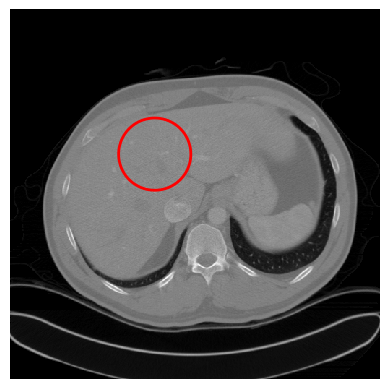

In [19]:
c = np.array([200, 200])
r = 50
w, h = img.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
phi0 = np.sqrt( (X - c[0])**2 + (Y - c[1])**2) - r

plot_levelset(phi0, 0, img)

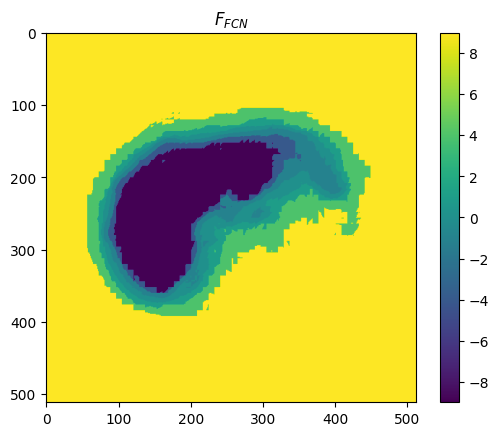


Iter 0
|curvature| 0.002288386439429191 2.12046457124701
norm_grad_phi 0.0 1.0
F_CV -0.2298319362903962 0.36613420480337466
G -10.156275179541584 9.739744723529327 
phi -53.780048114904034 393.87160674151744

Iter 50
|curvature| 0.0 2.1282562193245624
norm_grad_phi 99.02143209429002 523.6217908636738
F_CV -0.23250278635514987 0.37394264214344874
G -13.66405427796757 10.897653660918442 
phi -28966.030261991742 194581.98540544417

Iter 100
|curvature| 0.0 2.128667410141423
norm_grad_phi 120.05894640811572 522.233808312053
F_CV -0.23385183899842546 0.3793229918128302
G -13.665469303568617 10.886752248048253 
phi -30925.743081244582 190974.89000522735

Iter 150
|curvature| 0.0 2.128777895307518
norm_grad_phi 60.29649778392126 521.6557207508024
F_CV -0.2351626815216713 0.3847935300106752
G -13.666597099089415 10.928474971588603 
phi -32719.49455703658 187353.37530217654

Iter 200
|curvature| 0.0 2.1287196939664588
norm_grad_phi 0.06856719516963801 521.7631702140034
F_CV -0.2373182333202456

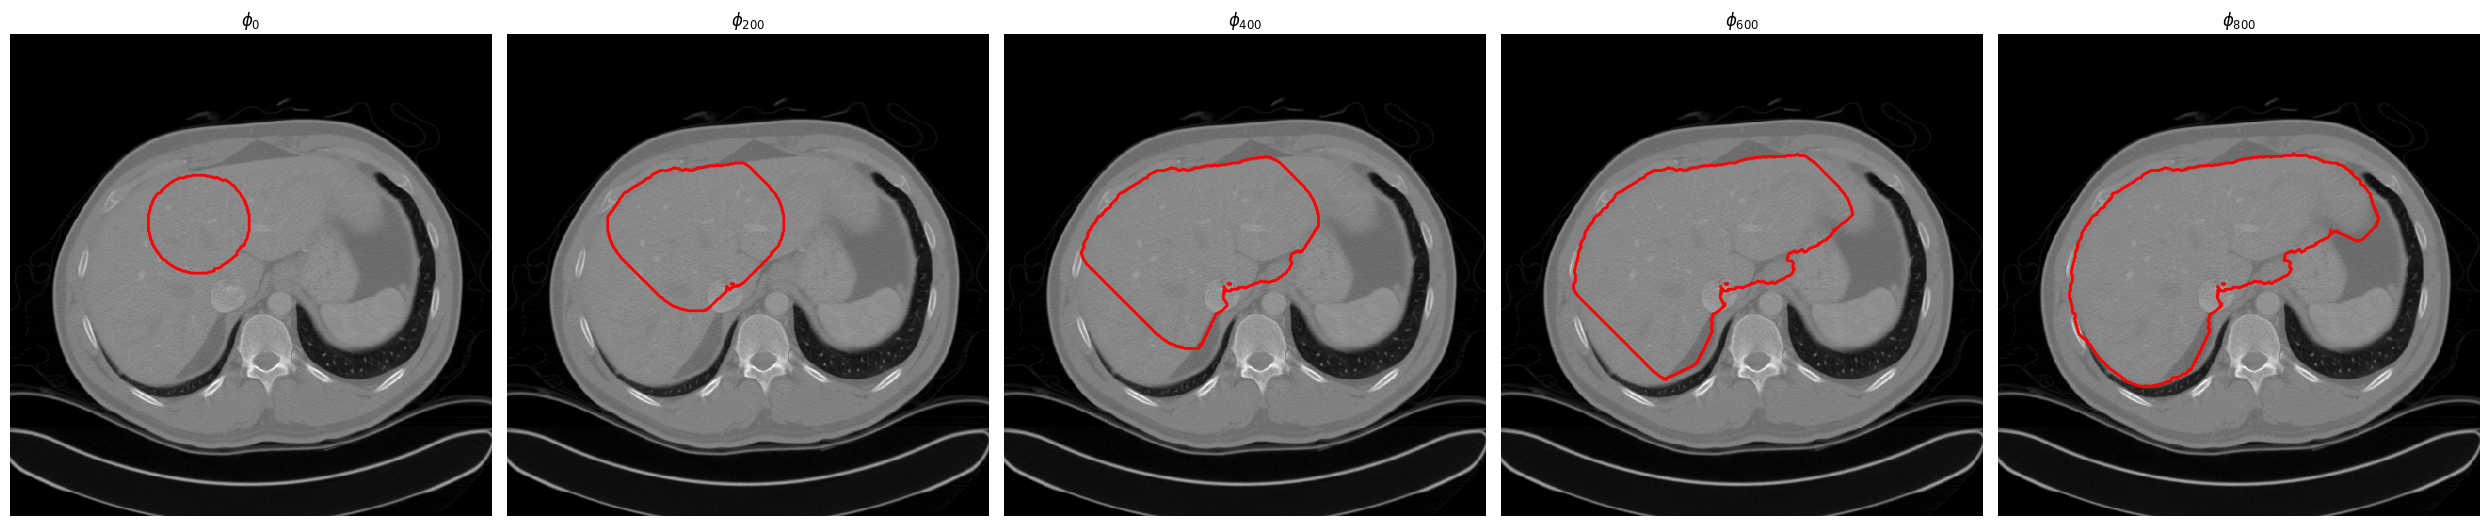

In [34]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.01, 1, 5],
                chan_vese='global',
                local_region_r=10,
                polynomial_fcn_force_order=2,
                add_edge_info=False,
                verbose=True)

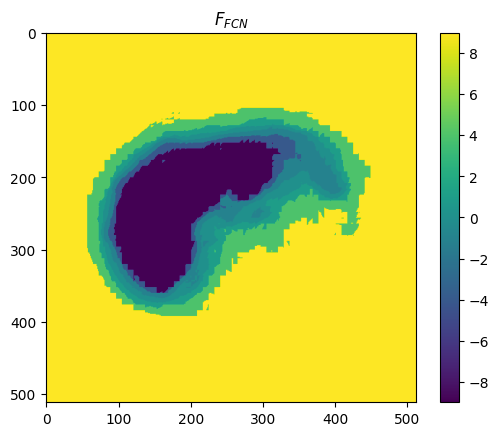


Iter 0
curvature -2.120 2.000
norm_grad_phi 0.000 1.000
F_CV -0.882, 0.376
G -13.413 10.878 
phi -54.176 393.412

Iter 100
curvature -2.129 1.865
norm_grad_phi 1.255 522.141
F_CV -0.882, 0.387
G -13.441 11.688 
phi -29471.340 190973.301

Iter 200
curvature -2.129 1.809
norm_grad_phi 1.222 522.102
F_CV -0.882, 0.391
G -13.445 11.771 
phi -33024.981 183728.809

Iter 300
curvature -2.124 1.998
norm_grad_phi 0.100 522.124
F_CV -0.882, 0.404
G -13.388 11.485 
phi -35142.398 177501.923

Iter 400
curvature -2.121 1.791
norm_grad_phi 0.100 521.732
F_CV -0.882, 0.404
G -13.442 11.235 
phi -35880.089 170860.495

Iter 500
curvature -2.126 1.791
norm_grad_phi 0.117 521.268
F_CV -0.882, 0.412
G -13.462 11.055 
phi -36756.916 170751.779

Iter 600
curvature -2.129 1.752
norm_grad_phi 0.117 521.715
F_CV -0.882, 0.412
G -13.379 11.079 
phi -37411.184 170751.779

Iter 700
curvature -2.129 1.784
norm_grad_phi 0.051 524.578
F_CV -0.882, 0.412
G -13.379 11.093 
phi -37411.184 170277.046

Iter 800
curvatur

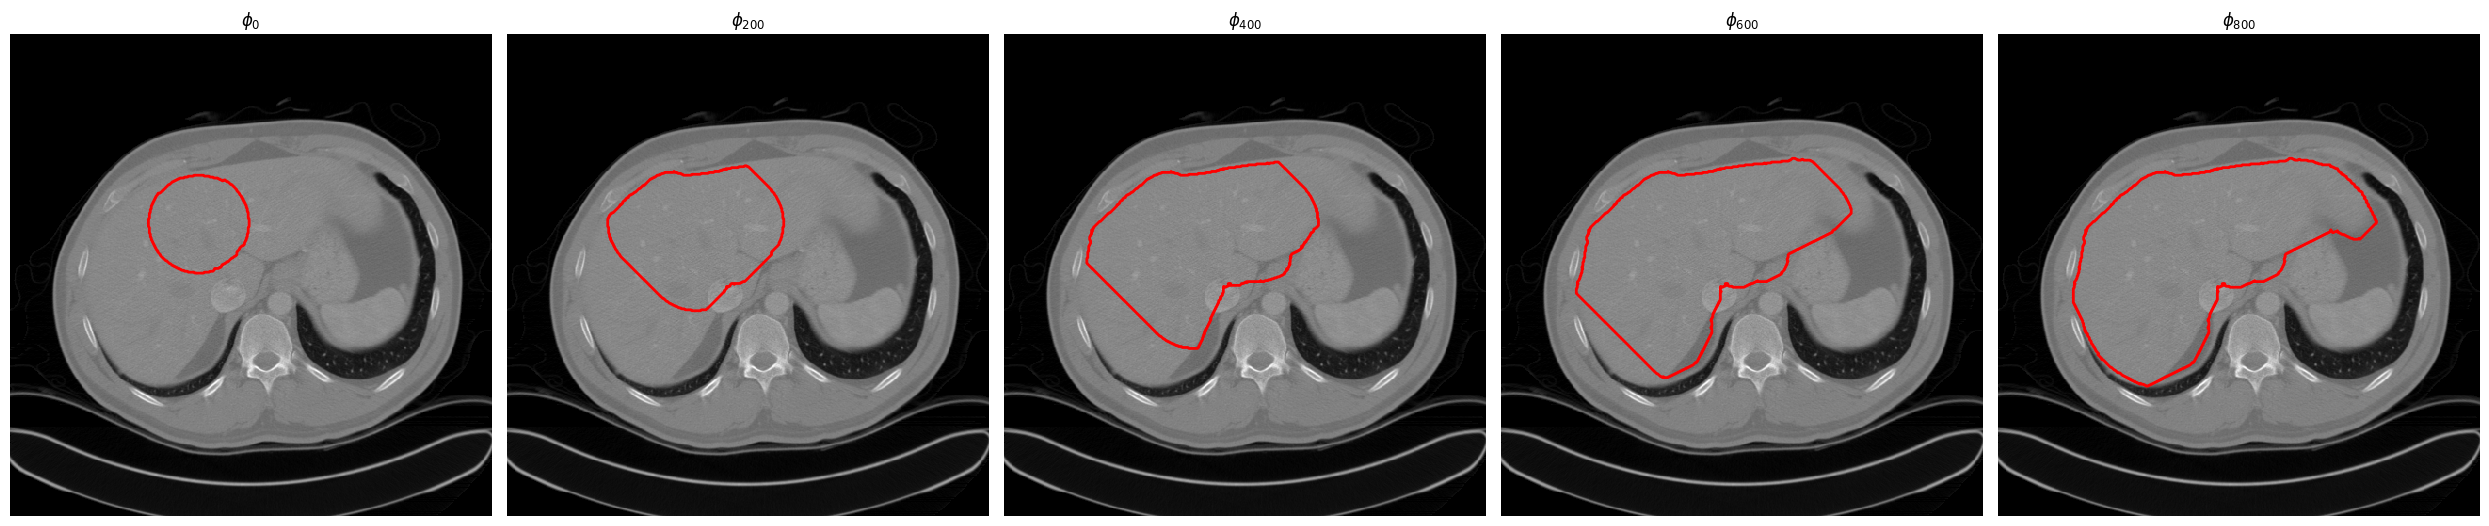

In [36]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.01, 1, 5],
                chan_vese='local',
                local_region_r=10,
                polynomial_fcn_force_order=2,
                add_edge_info=False,
                verbose=True)

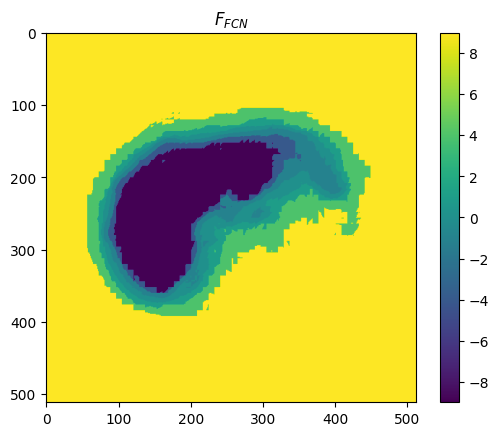


Iter 0
curvature -2.120 2.000
norm_grad_phi 0.000 1.000
F_CV -0.230, 0.366
G -1.155 1.831 
phi -50.180 390.273

Iter 100
curvature -2.127 1.780
norm_grad_phi 0.467 519.202
F_CV -0.232, 0.375
G -3.988 7.328 
phi -29471.283 193482.328

Iter 200
curvature -2.126 1.745
norm_grad_phi 0.592 520.132
F_CV -0.234, 0.385
G -4.457 7.309 
phi -35294.991 187334.514

Iter 300
curvature -2.126 1.809
norm_grad_phi 0.848 518.806
F_CV -0.237, 0.399
G -4.014 7.291 
phi -41776.586 180468.939

Iter 400
curvature -2.123 1.811
norm_grad_phi 0.268 520.317
F_CV -0.238, 0.412
G -4.008 7.275 
phi -46220.358 173785.276

Iter 500
curvature -2.127 1.729
norm_grad_phi 0.061 520.381
F_CV -0.238, 0.424
G -3.993 7.302 
phi -49546.006 168152.169

Iter 600
curvature -2.127 1.838
norm_grad_phi 0.207 520.500
F_CV -0.241, 0.443
G -4.019 7.288 
phi -50437.185 160911.373

Iter 700
curvature -2.126 1.748
norm_grad_phi 0.215 519.320
F_CV -0.243, 0.466
G -5.283 7.275 
phi -52899.005 153672.583

Iter 800
curvature -2.127 1.679
n

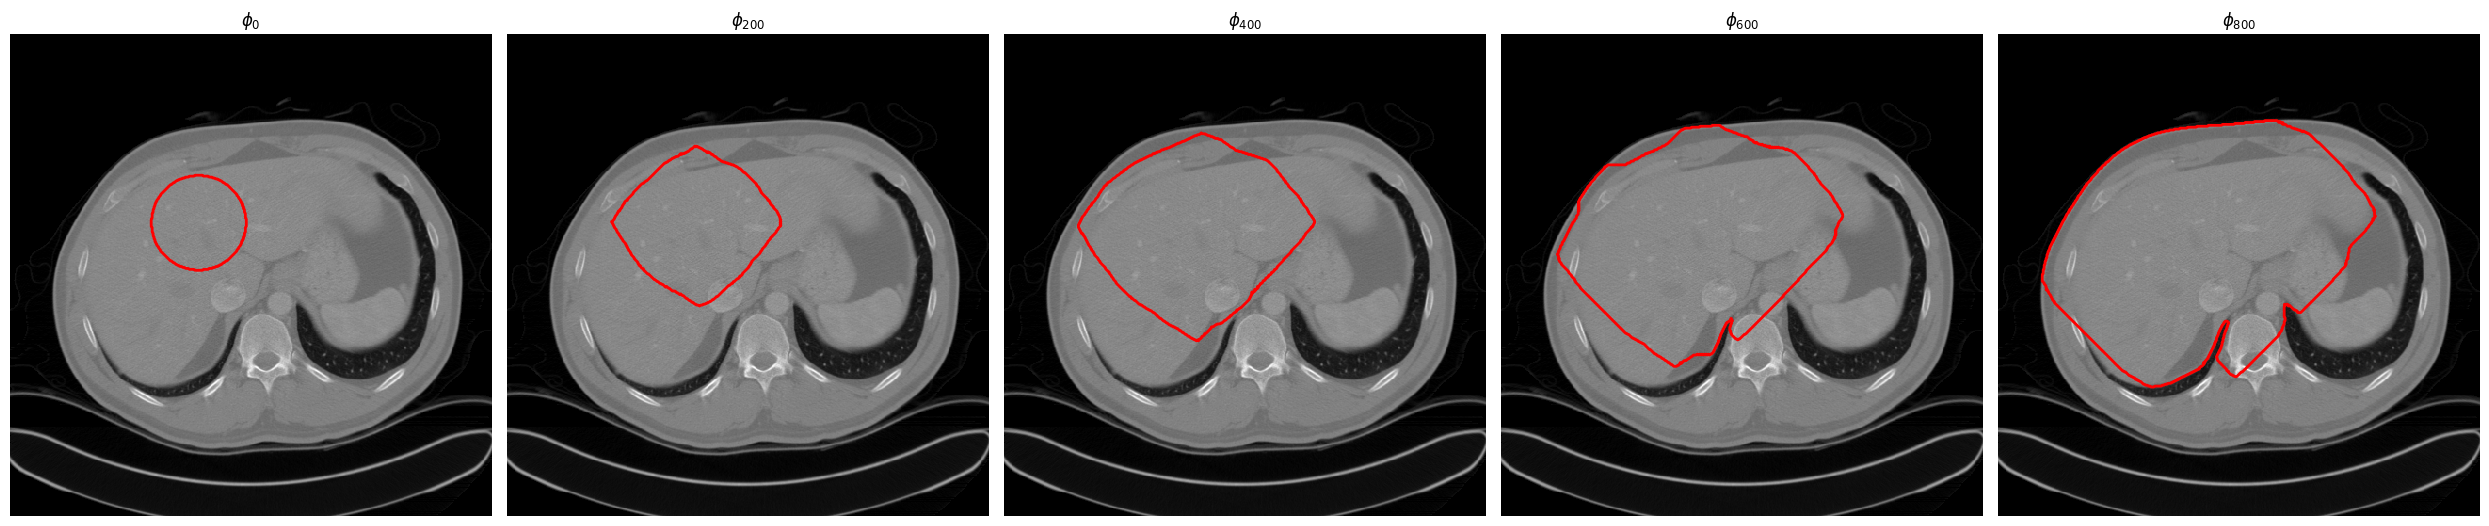

In [39]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.008, 0, 5],
                chan_vese='global',
                local_region_r=10,
                polynomial_fcn_force_order=2,
                add_edge_info=False,
                verbose=True)

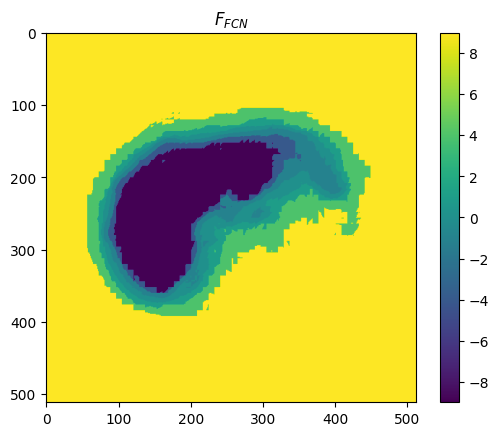

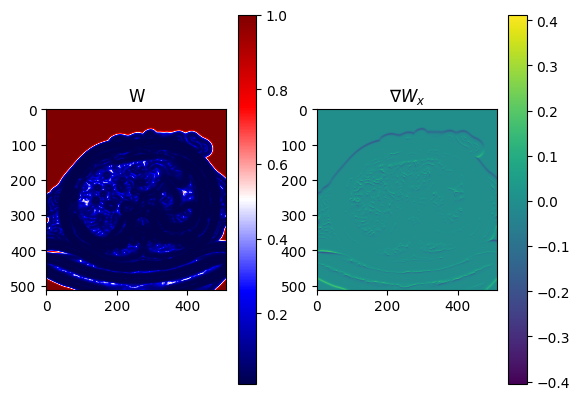


Iter 0
curvature -2.120 2.000
norm_grad_phi 0.000 1.000
inner_prod_grad -0.718 0.695
F_CV -0.230, 0.366
G -1.155 1.831 
phi -50.180 390.273

Iter 100
curvature -2.127 2.000
norm_grad_phi 0.315 519.090
inner_prod_grad -367.582 355.866
F_CV -0.232, 0.377
G -3.965 7.331 
phi -32041.365 192408.521

Iter 200
curvature -2.127 2.000
norm_grad_phi 0.185 519.118
inner_prod_grad -366.578 355.757
F_CV -0.233, 0.390
G -3.972 7.324 
phi -39282.204 185167.935

Iter 300
curvature -2.127 2.000
norm_grad_phi 0.223 518.881
inner_prod_grad -367.583 355.865
F_CV -0.234, 0.404
G -3.976 7.322 
phi -46523.053 177927.166

Iter 400
curvature -2.127 1.892
norm_grad_phi 0.075 519.221
inner_prod_grad -367.584 356.457
F_CV -0.233, 0.418
G -4.001 7.327 
phi -52325.469 170686.384

Iter 500
curvature -2.127 1.619
norm_grad_phi 0.047 519.417
inner_prod_grad -367.585 355.863
F_CV -0.236, 0.436
G -4.002 7.342 
phi -53668.028 163445.639

Iter 600
curvature -2.127 1.614
norm_grad_phi 1.166 519.086
inner_prod_grad -320.59

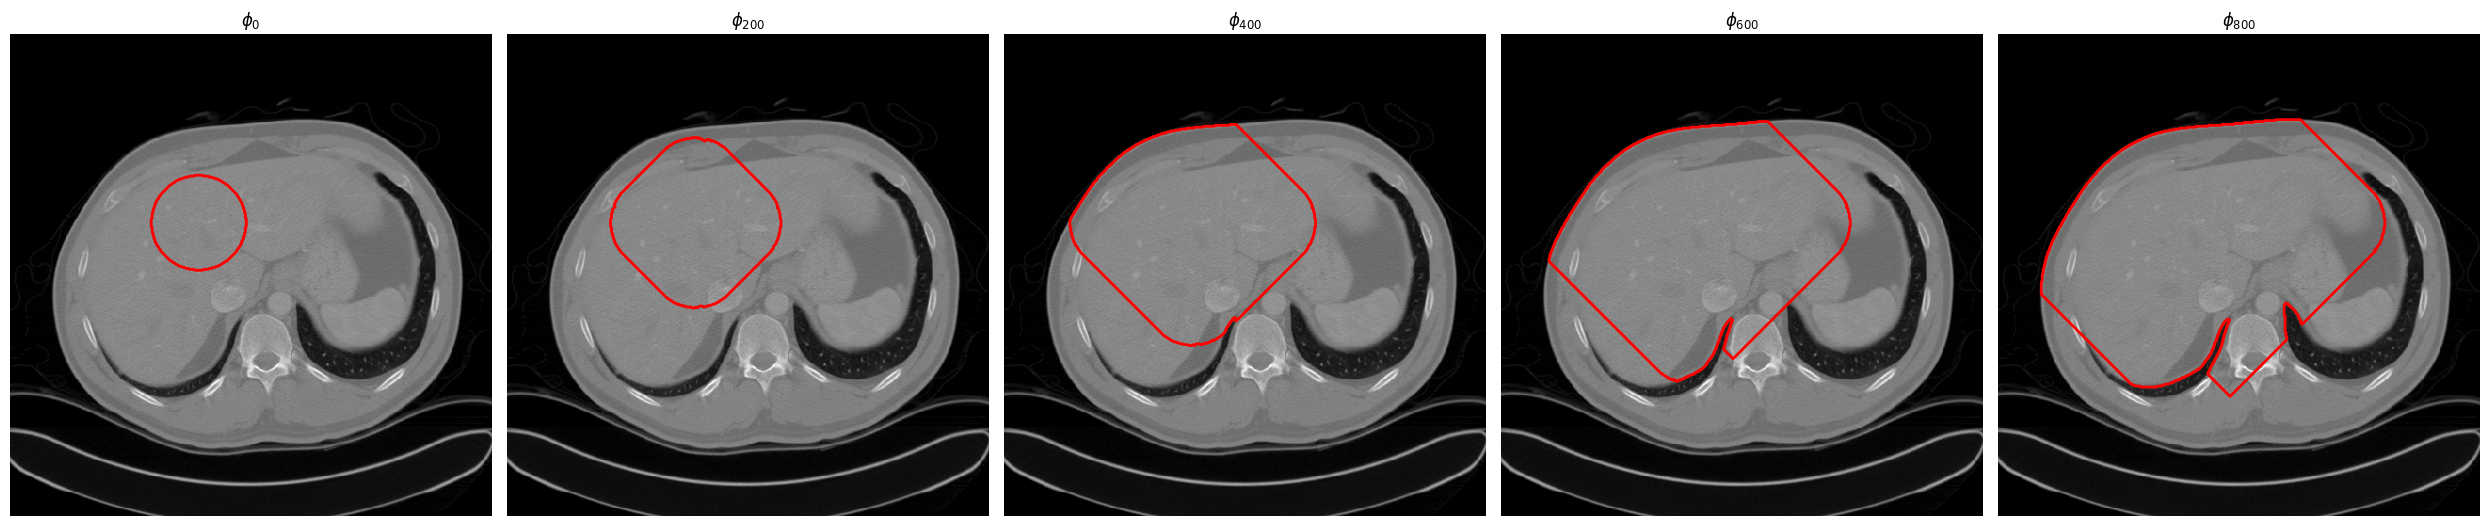

In [40]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.008, 0, 5],
                chan_vese='global',
                local_region_r=10,
                polynomial_fcn_force_order=2,
                add_edge_info=True,
                verbose=True)

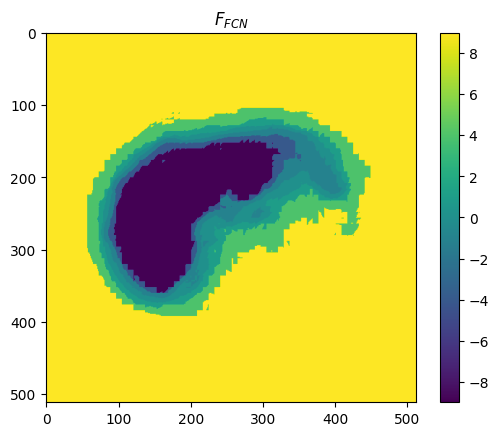


Iter 0
curvature -2.120 2.000 mean 0.000
norm_grad_phi 0.000 1.000 mean 1.000
F_CV -0.818, 0.374 mean -0.094
G -4.091 1.868 mean -0.468
phi -50.576 389.812 mean 156.615


In [22]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=400,
                redistancing_occur=5,
                weights=[.01, 0, 5],
                chan_vese='local',
                local_region_r=50,
                polynomial_fcn_force_order=2,
                add_edge_info=False,
                verbose=True)

In [ ]:
phi = solve_acm(img, pred_label_map, phi0, 
                tau=.4, niter=1000,
                redistancing_occur=5,
                weights=[.008, 0, 5],
                chan_vese='local',
                local_region_r=10,
                polynomial_fcn_force_order=2,
                add_edge_info=True,
                verbose=True)

In [309]:
g.flat[np.flatnonzero(g>3)] = 9
g

array([[0. , 0.5, 1. , 1.5, 2. ],
       [2.5, 3. , 9. , 9. , 9. ]])

In [311]:
np.unravel_index(3, (2, 3))

(1, 0)